# Food-101 Image Classifier — MobileNetV2 Transfer Learning

Train a food image classifier for the **Smart Nutrition Tracker** project.

- **Dataset**: Food-101 (101 categories, 101K images)
- **Model**: MobileNetV2 (pretrained on ImageNet)
- **Strategy**: 2-phase transfer learning
- **Output**: `food_classifier.pth` + `food_classes.json`

**Runtime**: Go to `Runtime > Change runtime type > T4 GPU`

## 1. Setup

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, models
from torchvision.datasets import Food101
import matplotlib.pyplot as plt
import numpy as np
import json
import time
import os
from collections import defaultdict

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Device: cuda
GPU: Tesla T4
Memory: 15.6 GB


## 2. Download Food-101 Dataset

In [3]:
# Data transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

print("Downloading Food-101 dataset (~5GB, takes a few minutes)...")
train_dataset = Food101(root='./data', split='train', download=True, transform=train_transform)
test_dataset = Food101(root='./data', split='test', download=True, transform=test_transform)

print(f"Training samples: {len(train_dataset):,}")
print(f"Test samples:     {len(test_dataset):,}")
print(f"Classes:          {len(train_dataset.classes)}")

100%|██████████| 5.00G/5.00G [03:48<00:00, 21.9MB/s]


Training samples: 75,750
Test samples:     25,250
Classes:          101


In [4]:
# Save class names for later use in the project
class_names = train_dataset.classes
class_to_idx = {name: i for i, name in enumerate(class_names)}

print("Food categories:")
for i, name in enumerate(class_names):
    print(f"  {i:3d}. {name.replace('_', ' ').title()}")

Food categories:
    0. Apple Pie
    1. Baby Back Ribs
    2. Baklava
    3. Beef Carpaccio
    4. Beef Tartare
    5. Beet Salad
    6. Beignets
    7. Bibimbap
    8. Bread Pudding
    9. Breakfast Burrito
   10. Bruschetta
   11. Caesar Salad
   12. Cannoli
   13. Caprese Salad
   14. Carrot Cake
   15. Ceviche
   16. Cheese Plate
   17. Cheesecake
   18. Chicken Curry
   19. Chicken Quesadilla
   20. Chicken Wings
   21. Chocolate Cake
   22. Chocolate Mousse
   23. Churros
   24. Clam Chowder
   25. Club Sandwich
   26. Crab Cakes
   27. Creme Brulee
   28. Croque Madame
   29. Cup Cakes
   30. Deviled Eggs
   31. Donuts
   32. Dumplings
   33. Edamame
   34. Eggs Benedict
   35. Escargots
   36. Falafel
   37. Filet Mignon
   38. Fish And Chips
   39. Foie Gras
   40. French Fries
   41. French Onion Soup
   42. French Toast
   43. Fried Calamari
   44. Fried Rice
   45. Frozen Yogurt
   46. Garlic Bread
   47. Gnocchi
   48. Greek Salad
   49. Grilled Cheese Sandwich
   50. Gri

## 3. DataLoaders

In [5]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=2, pin_memory=True)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches:  {len(test_loader)}")

Train batches: 1184
Test batches:  395


## 4. Visualize Sample Images

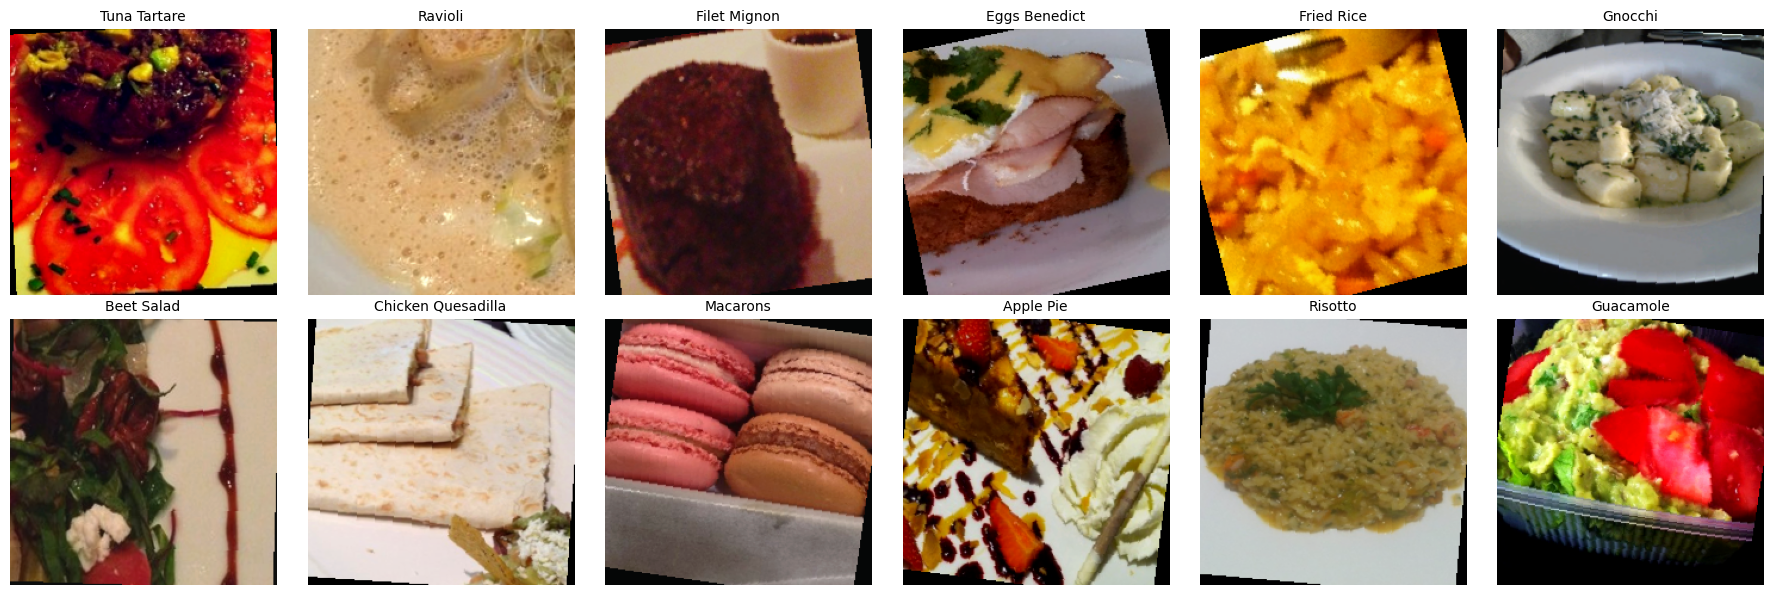

In [6]:
def show_samples(dataset, n=12):
    """Show sample images from the dataset."""
    fig, axes = plt.subplots(2, 6, figsize=(18, 6))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    indices = np.random.choice(len(dataset), n, replace=False)
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = img.numpy().transpose(1, 2, 0)
        img = std * img + mean  # denormalize
        img = np.clip(img, 0, 1)

        ax = axes[i // 6][i % 6]
        ax.imshow(img)
        ax.set_title(class_names[label].replace('_', ' ').title(), fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_samples(train_dataset)

## 5. Build Model — MobileNetV2 + Custom Head

In [7]:
def build_model(num_classes=101, freeze_backbone=True):
    """MobileNetV2 with custom classifier head."""
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

    # Freeze backbone
    if freeze_backbone:
        for param in model.features.parameters():
            param.requires_grad = False

    # Replace classifier (original: 1280 -> 1000 for ImageNet)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(1280, num_classes)
    )

    return model.to(device)

model = build_model(num_classes=101, freeze_backbone=True)

# Count parameters
total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters:     {total:,}")
print(f"Trainable parameters: {trainable:,}")
print(f"Frozen parameters:    {total - trainable:,}")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 93.5MB/s]


Total parameters:     2,353,253
Trainable parameters: 129,381
Frozen parameters:    2,223,872


## 6. Training Functions

In [8]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        if (batch_idx + 1) % 200 == 0:
            print(f"    batch {batch_idx+1}/{len(loader)} — "
                  f"loss: {total_loss/total:.4f}, acc: {100.*correct/total:.1f}%")

    return total_loss / total, correct / total


def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total

## 7. Phase 1 — Train Classifier Head Only (backbone frozen)

Fast convergence: only the final layer learns to map ImageNet features to food categories.

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

PHASE1_EPOCHS = 5
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

print("=" * 60)
print("PHASE 1: Training classifier head (backbone frozen)")
print("=" * 60)

for epoch in range(PHASE1_EPOCHS):
    start = time.time()
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    scheduler.step()
    elapsed = time.time() - start

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)

    print(f"Epoch {epoch+1}/{PHASE1_EPOCHS} ({elapsed:.0f}s) — "
          f"Train: {100*train_acc:.1f}% | Test: {100*test_acc:.1f}% | "
          f"LR: {scheduler.get_last_lr()[0]:.6f}")

print(f"\nPhase 1 complete — Test accuracy: {100*history['test_acc'][-1]:.1f}%")

PHASE 1: Training classifier head (backbone frozen)
    batch 200/1184 — loss: 3.8285, acc: 16.7%
    batch 400/1184 — loss: 3.4433, acc: 23.1%
    batch 600/1184 — loss: 3.2454, acc: 26.4%
    batch 800/1184 — loss: 3.1281, acc: 28.3%
    batch 1000/1184 — loss: 3.0500, acc: 29.7%
Epoch 1/5 (639s) — Train: 30.7% | Test: 52.4% | LR: 0.001000
    batch 200/1184 — loss: 2.6453, acc: 36.9%
    batch 400/1184 — loss: 2.6444, acc: 36.9%
    batch 600/1184 — loss: 2.6524, acc: 36.8%
    batch 800/1184 — loss: 2.6529, acc: 36.9%
    batch 1000/1184 — loss: 2.6508, acc: 37.0%
Epoch 2/5 (604s) — Train: 37.2% | Test: 54.2% | LR: 0.001000
    batch 200/1184 — loss: 2.6072, acc: 38.0%
    batch 400/1184 — loss: 2.6076, acc: 37.8%
    batch 600/1184 — loss: 2.6020, acc: 38.0%
    batch 800/1184 — loss: 2.6031, acc: 38.2%
    batch 1000/1184 — loss: 2.6042, acc: 38.2%
Epoch 3/5 (594s) — Train: 38.1% | Test: 55.5% | LR: 0.000500
    batch 200/1184 — loss: 2.4969, acc: 40.3%
    batch 400/1184 — loss:

## 8. Phase 2 — Fine-tune Entire Model (backbone unfrozen)

Unfreeze all layers and train with a lower learning rate for higher accuracy.

In [10]:
# Unfreeze backbone
for param in model.features.parameters():
    param.requires_grad = True

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters after unfreeze: {trainable:,}")

# Lower LR to avoid destroying pretrained weights
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

PHASE2_EPOCHS = 10
best_acc = max(history['test_acc'])

print("=" * 60)
print("PHASE 2: Fine-tuning entire model")
print("=" * 60)

for epoch in range(PHASE2_EPOCHS):
    start = time.time()
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    scheduler.step()
    elapsed = time.time() - start

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)

    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), 'food_classifier_best.pth')
        marker = ' << BEST'
    else:
        marker = ''

    total_epoch = PHASE1_EPOCHS + epoch + 1
    print(f"Epoch {total_epoch}/{PHASE1_EPOCHS+PHASE2_EPOCHS} ({elapsed:.0f}s) — "
          f"Train: {100*train_acc:.1f}% | Test: {100*test_acc:.1f}%{marker}")

print(f"\nPhase 2 complete — Best test accuracy: {100*best_acc:.1f}%")

Trainable parameters after unfreeze: 2,353,253
PHASE 2: Fine-tuning entire model
    batch 200/1184 — loss: 2.2401, acc: 45.5%
    batch 400/1184 — loss: 2.1731, acc: 46.8%
    batch 600/1184 — loss: 2.1189, acc: 47.9%
    batch 800/1184 — loss: 2.0774, acc: 48.9%
    batch 1000/1184 — loss: 2.0420, acc: 49.8%
Epoch 6/15 (641s) — Train: 50.5% | Test: 71.9% << BEST
    batch 200/1184 — loss: 1.7200, acc: 56.0%
    batch 400/1184 — loss: 1.7189, acc: 56.7%
    batch 600/1184 — loss: 1.7104, acc: 56.9%
    batch 800/1184 — loss: 1.7083, acc: 57.1%
    batch 1000/1184 — loss: 1.6977, acc: 57.3%
Epoch 7/15 (639s) — Train: 57.4% | Test: 74.6% << BEST
    batch 200/1184 — loss: 1.5639, acc: 59.9%
    batch 400/1184 — loss: 1.5708, acc: 59.9%
    batch 600/1184 — loss: 1.5582, acc: 60.3%
    batch 800/1184 — loss: 1.5524, acc: 60.3%
    batch 1000/1184 — loss: 1.5420, acc: 60.6%
Epoch 8/15 (638s) — Train: 60.8% | Test: 77.0% << BEST
    batch 200/1184 — loss: 1.4429, acc: 62.8%
    batch 400/1

## 9. Training Curves

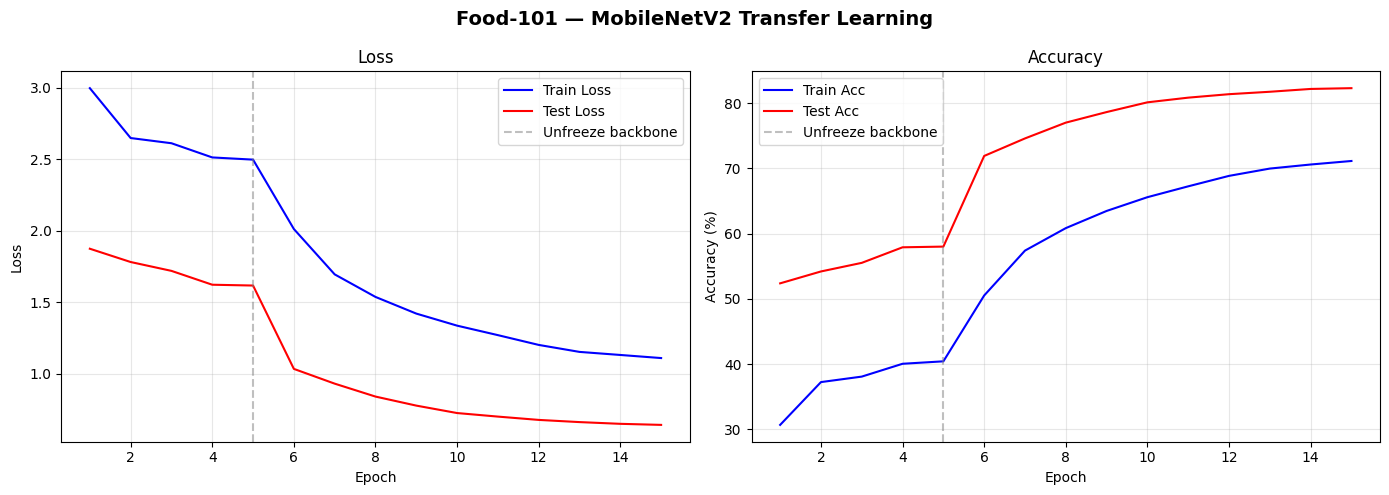

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(history['train_loss']) + 1)
phase1_end = PHASE1_EPOCHS

# Loss
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, history['test_loss'], 'r-', label='Test Loss')
ax1.axvline(x=phase1_end, color='gray', linestyle='--', alpha=0.5, label='Unfreeze backbone')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(epochs, [a*100 for a in history['train_acc']], 'b-', label='Train Acc')
ax2.plot(epochs, [a*100 for a in history['test_acc']], 'r-', label='Test Acc')
ax2.axvline(x=phase1_end, color='gray', linestyle='--', alpha=0.5, label='Unfreeze backbone')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Food-101 — MobileNetV2 Transfer Learning', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Evaluate on Test Set

In [12]:
# Load best model
model.load_state_dict(torch.load('food_classifier_best.pth'))
model.eval()

# Collect all predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Overall accuracy
top1_acc = (all_preds == all_labels).mean()
print(f"Top-1 Accuracy: {100*top1_acc:.2f}%")

# Per-class accuracy (top 10 and bottom 10)
class_correct = defaultdict(int)
class_total = defaultdict(int)
for pred, label in zip(all_preds, all_labels):
    class_total[label] += 1
    if pred == label:
        class_correct[label] += 1

class_acc = {cls: class_correct[cls] / class_total[cls] for cls in class_total}
sorted_classes = sorted(class_acc.items(), key=lambda x: x[1], reverse=True)

print(f"\nTop 10 easiest classes:")
for cls_idx, acc in sorted_classes[:10]:
    print(f"  {class_names[cls_idx]:25s} {100*acc:.1f}%")

print(f"\nTop 10 hardest classes:")
for cls_idx, acc in sorted_classes[-10:]:
    print(f"  {class_names[cls_idx]:25s} {100*acc:.1f}%")

Top-1 Accuracy: 82.28%

Top 10 easiest classes:
  edamame                   99.2%
  frozen_yogurt             94.8%
  sashimi                   94.4%
  spaghetti_carbonara       94.4%
  macarons                  94.4%
  deviled_eggs              94.0%
  hot_and_sour_soup         93.2%
  miso_soup                 93.2%
  french_fries              93.2%
  seaweed_salad             93.2%

Top 10 hardest classes:
  bruschetta                69.2%
  lasagna                   68.8%
  chocolate_mousse          67.2%
  huevos_rancheros          65.6%
  bread_pudding             62.0%
  ravioli                   61.6%
  foie_gras                 59.2%
  pork_chop                 56.0%
  apple_pie                 56.0%
  steak                     54.8%


## 11. Sample Predictions

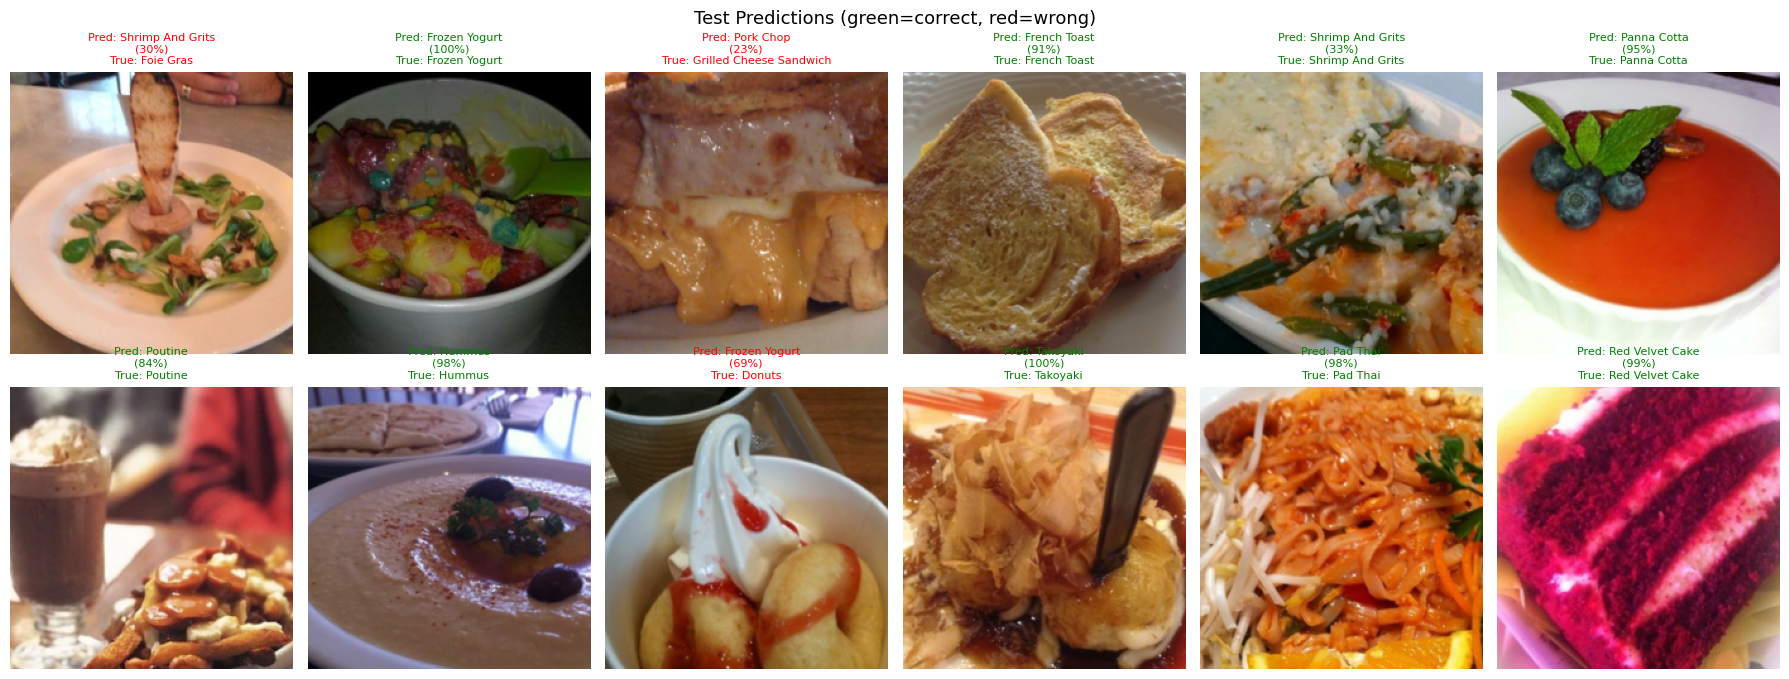

In [13]:
def show_predictions(model, dataset, n=12):
    """Show predictions on random test images."""
    model.eval()
    fig, axes = plt.subplots(2, 6, figsize=(18, 7))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    indices = np.random.choice(len(dataset), n, replace=False)

    for i, idx in enumerate(indices):
        img, label = dataset[idx]

        # Predict
        with torch.no_grad():
            output = model(img.unsqueeze(0).to(device))
            probs = torch.softmax(output, dim=1)
            confidence, predicted = probs.max(1)

        # Denormalize for display
        img_np = img.numpy().transpose(1, 2, 0)
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)

        ax = axes[i // 6][i % 6]
        ax.imshow(img_np)

        pred_name = class_names[predicted.item()].replace('_', ' ').title()
        true_name = class_names[label].replace('_', ' ').title()
        conf = confidence.item() * 100

        correct = predicted.item() == label
        color = 'green' if correct else 'red'
        ax.set_title(f"Pred: {pred_name}\n({conf:.0f}%)\nTrue: {true_name}",
                     fontsize=8, color=color)
        ax.axis('off')

    plt.suptitle('Test Predictions (green=correct, red=wrong)', fontsize=13)
    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

show_predictions(model, test_dataset)

## 12. Measure Inference Speed

This is important for protocol benchmarking — we need to know the model's inference time
so we can separate it from protocol overhead.

In [14]:
# Benchmark inference speed
model.eval()
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Warmup
for _ in range(20):
    with torch.no_grad():
        _ = model(dummy_input)

# Measure
if device.type == 'cuda':
    torch.cuda.synchronize()

times = []
for _ in range(100):
    start = time.perf_counter()
    with torch.no_grad():
        _ = model(dummy_input)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    times.append((time.perf_counter() - start) * 1000)

times = np.array(times)
print(f"Inference speed (single image):")
print(f"  Mean:  {times.mean():.2f} ms")
print(f"  P50:   {np.percentile(times, 50):.2f} ms")
print(f"  P95:   {np.percentile(times, 95):.2f} ms")
print(f"  P99:   {np.percentile(times, 99):.2f} ms")
print(f"\nThis is the baseline inference time.")
print(f"Protocol overhead = total_time - inference_time")

Inference speed (single image):
  Mean:  5.28 ms
  P50:   5.08 ms
  P95:   6.03 ms
  P99:   9.99 ms

This is the baseline inference time.
Protocol overhead = total_time - inference_time


## 13. Export Model for Deployment

Save everything needed to run inference in the Smart Nutrition Tracker project.

In [15]:
# 1. Save model weights
torch.save(model.state_dict(), 'food_classifier.pth')

# 2. Save class mapping
class_info = {
    'classes': class_names,
    'class_to_idx': class_to_idx,
    'num_classes': len(class_names),
    'model_arch': 'mobilenet_v2',
    'input_size': 224,
    'normalize_mean': [0.485, 0.456, 0.406],
    'normalize_std': [0.229, 0.224, 0.225],
    'accuracy': float(f'{100*best_acc:.2f}'),
    'inference_time_ms': float(f'{times.mean():.2f}')
}

with open('food_classes.json', 'w') as f:
    json.dump(class_info, f, indent=2)

# 3. Save training history
with open('training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

# Check file sizes
for fname in ['food_classifier.pth', 'food_classifier_best.pth', 'food_classes.json']:
    size = os.path.getsize(fname)
    print(f"{fname}: {size / 1e6:.1f} MB")

print("\nFiles to download:")
print("  food_classifier.pth   — model weights (copy to project root)")
print("  food_classes.json     — class names + config (copy to project root)")

food_classifier.pth: 9.7 MB
food_classifier_best.pth: 9.7 MB
food_classes.json: 0.0 MB

Files to download:
  food_classifier.pth   — model weights (copy to project root)
  food_classes.json     — class names + config (copy to project root)


## 14. Export as TorchScript (optional, for faster CPU inference)

TorchScript compiles the model for optimized inference without Python overhead.
Use this if you deploy on CPU (your Docker containers).

In [16]:
# Move to CPU for export (your containers run on CPU)
model_cpu = model.cpu()
model_cpu.eval()

# Trace the model
example_input = torch.randn(1, 3, 224, 224)
traced_model = torch.jit.trace(model_cpu, example_input)
traced_model.save('food_classifier_traced.pt')

# Benchmark CPU inference (this is what your containers will do)
cpu_times = []
for _ in range(50):
    start = time.perf_counter()
    with torch.no_grad():
        _ = traced_model(example_input)
    cpu_times.append((time.perf_counter() - start) * 1000)

cpu_times = np.array(cpu_times)
print(f"CPU inference (TorchScript):")
print(f"  Mean:  {cpu_times.mean():.2f} ms")
print(f"  P50:   {np.percentile(cpu_times, 50):.2f} ms")
print(f"  P95:   {np.percentile(cpu_times, 95):.2f} ms")

size = os.path.getsize('food_classifier_traced.pt')
print(f"\nfood_classifier_traced.pt: {size / 1e6:.1f} MB")
print("\nUse this file for deployment — faster CPU inference.")

CPU inference (TorchScript):
  Mean:  76.92 ms
  P50:   75.92 ms
  P95:   85.24 ms

food_classifier_traced.pt: 10.0 MB

Use this file for deployment — faster CPU inference.


## 15. Download Files

Run this cell to download the trained model files to your computer.
Then copy them to your `my_product/` project directory.

In [17]:
from google.colab import files

print("Downloading model files...")
print("Copy these files to: my_product/models/")
print()

files.download('food_classifier.pth')
files.download('food_classifier_traced.pt')
files.download('food_classes.json')
files.download('training_history.json')
files.download('training_curves.png')
files.download('sample_predictions.png')

Copy these files to: my_product/models/



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 16. Quick Test — Classify a Custom Image

Upload any food image to test the model before downloading.

In [ ]:
from google.colab import files as colab_files
from PIL import Image

print("Upload a food image to test:")
uploaded = colab_files.upload()

for filename in uploaded:
    # Load and preprocess
    img = Image.open(filename).convert('RGB')
    img_tensor = test_transform(img).unsqueeze(0).to(device)

    # Predict
    model.to(device)
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)

    # Top 5 predictions
    top5_probs, top5_indices = probs.topk(5)

    print(f"\nResults for '{filename}':")
    print("-" * 40)
    for prob, idx in zip(top5_probs[0], top5_indices[0]):
        name = class_names[idx.item()].replace('_', ' ').title()
        print(f"  {name:25s} {100*prob.item():.1f}%")

    # Show image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    winner = class_names[top5_indices[0][0].item()].replace('_', ' ').title()
    plt.title(f"Prediction: {winner} ({100*top5_probs[0][0].item():.1f}%)")
    plt.axis('off')
    plt.show()

Upload a food image to test:


---

## Next Steps

After downloading the model files:

1. Copy `food_classifier.pth` and `food_classes.json` to `my_product/models/`
2. The integration code in `ml_food_classifier.py` will load these files
3. Run `benchmark_ml.py` to compare A2A vs PNP vs TOON with image payloads

Expected model size: ~9 MB (MobileNetV2 is lightweight)